<a href="https://colab.research.google.com/github/jpsicilia/spotify_analysis/blob/main/notebooks/spotify_analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importar Librerias


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import networkx as nx
import plotly.graph_objects as go
from itertools import combinations
from collections import Counter





###Cargar Data

In [53]:
df = pd.read_csv('songs.csv')
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


###Análisis Exploratorio Inicial

In [54]:
# Información general del DataFrame (estructura, tipos de datos)
df.info()

# Estadísticas descriptivas (tendencia central, dispersión, frecuencias)
df.describe(include='all')

# Detección de valores nulos por columna
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


,0
artist,0
song,0
duration_ms,0
explicit,0
year,0
popularity,0
danceability,0
energy,0
key,0
loudness,0


###Limpieza de Datos y Feature Engineering

In [55]:
# Verificar duplicados exactos
print("Duplicados exactos:", df.duplicated().sum())

# Eliminarlos
df = df.drop_duplicates()

# Revisar duplicados en canciones con mismo artista
print("Duplicados artista + canción:", df.duplicated(subset=["artist", "song"]).sum())

# Nos quedamos con la más popular
df = df.sort_values(by="popularity", ascending=False).drop_duplicates(subset=["artist", "song"], keep="first")

# Arreglar géneros vacíos
df['genre'] = df['genre'].replace('set()', 'desconocido')

# Crear nueva feature: duración en minutos
df['duration_min'] = df['duration_ms'] / 60000  # Convertir ms a minutos

# Crear columna normalizada de géneros
df['genre_clean'] = (
    df['genre']
    .str.split(',')  # 1. Divide los géneros separados por comas en listas.
    .apply(lambda x: ', '.join(  # 2. Para cada lista:
        sorted([i.strip().lower() for i in x])  # 3. a) Limpia espacios, b) convierte a minúsculas, c) ordena.
    ))
)
# Resetear el índice
df = df.reset_index(drop=True)


Duplicados exactos: 59
Duplicados artista + canción: 15


### ¿Qué artistas generan más “engagement”, popularidad ponderada por cantidad de canciones


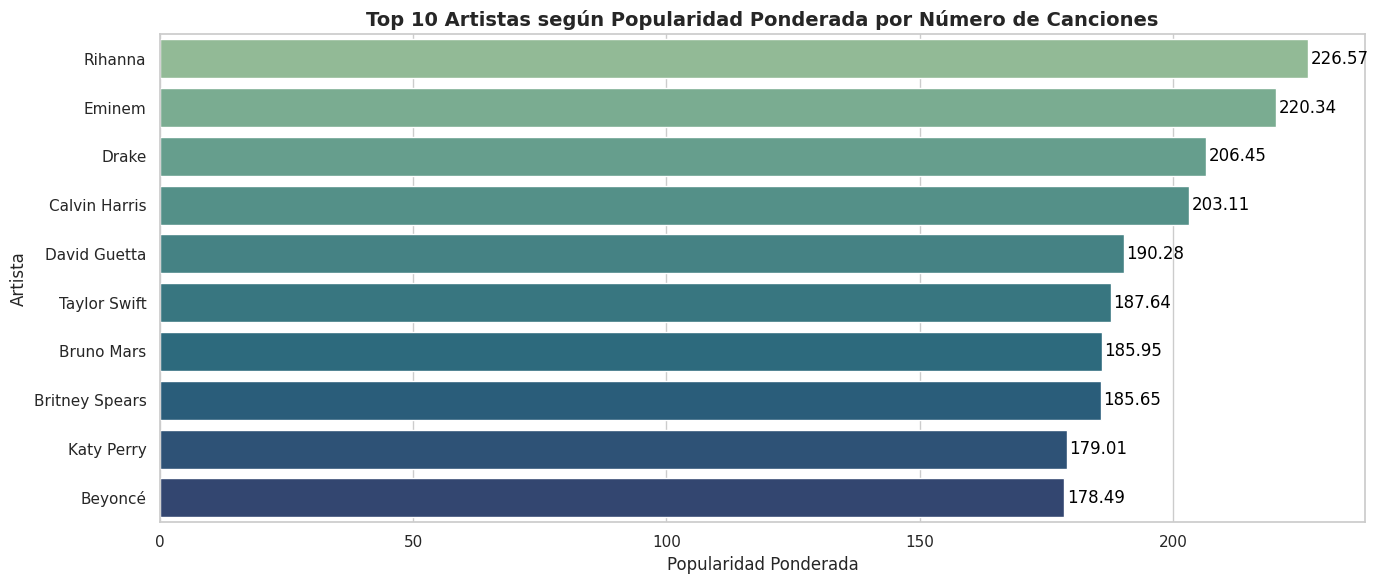

In [67]:
# Función de score ponderado
def score_ponderado(series):
    n = len(series)
    mean_pop = series.mean()
    peso = np.log(n)
    return mean_pop * peso

# Calcular el score ponderado
top_artists = df.groupby("artist")["popularity"].agg(score_ponderado)
top_artists = top_artists.sort_values(ascending=False).head(10)

# Preparar DataFrame para seaborn
df_plot = pd.DataFrame({
    'Artista': top_artists.index,
    'Score': top_artists.values
})

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

# Graficar sin warnings
ax = sns.barplot(
    data=df_plot,
    x="Score",
    y="Artista",
    hue="Artista",
    palette="crest",

)

# Títulos y etiquetas
ax.set_title(
    "Top 10 Artistas según Popularidad Ponderada por Número de Canciones",
    fontsize=14, weight='bold'
)
ax.set_xlabel(
    "Popularidad Ponderada",
    fontsize=12
)
ax.set_ylabel("Artista", fontsize=12)

# Añadir etiquetas dentro o al final de las barras
for i, (score, artista) in enumerate(zip(df_plot['Score'], df_plot['Artista'])):
    ax.text(score + 0.5, i, f"{score:.2f}", color='black', va='center')

plt.tight_layout()
plt.show()

###Géneros “premium”: popularidad vs volumen

In [57]:
# Agrupar por combinaciones de géneros
genero_stats = (
    df.groupby('genre_clean')['popularity']
      .agg(['count', 'mean'])
      .rename(columns={'count': 'num_canciones', 'mean': 'popularidad_media'})
      .reset_index()
)

# Calcular popularidad ponderada (por cantidad de canciones)
genero_stats['popularidad_ponderada'] = genero_stats['popularidad_media'] * np.log1p(genero_stats['num_canciones'])

# Ordenar para ver los más "fuertes"
genero_stats = genero_stats.sort_values(by='popularidad_ponderada', ascending=False)

In [58]:
genero_stats.head(10)

,genre_clean,num_canciones,popularidad_media,popularidad_ponderada
34,"hip hop, pop",265,64.086792,357.828369
44,pop,411,59.128954,356.016811
35,"hip hop, pop, r&b",234,59.512821,324.915333
31,hip hop,120,64.241667,308.089578
45,"pop, r&b",170,57.911765,297.762810
15,"dance/electronic, pop",213,53.741784,288.377124
50,rock,57,66.754386,271.052380
46,"pop, rock",65,62.676923,262.594668
12,"dance/electronic, hip hop, pop",75,59.546667,257.880735
43,"metal, rock",36,70.527778,254.670016


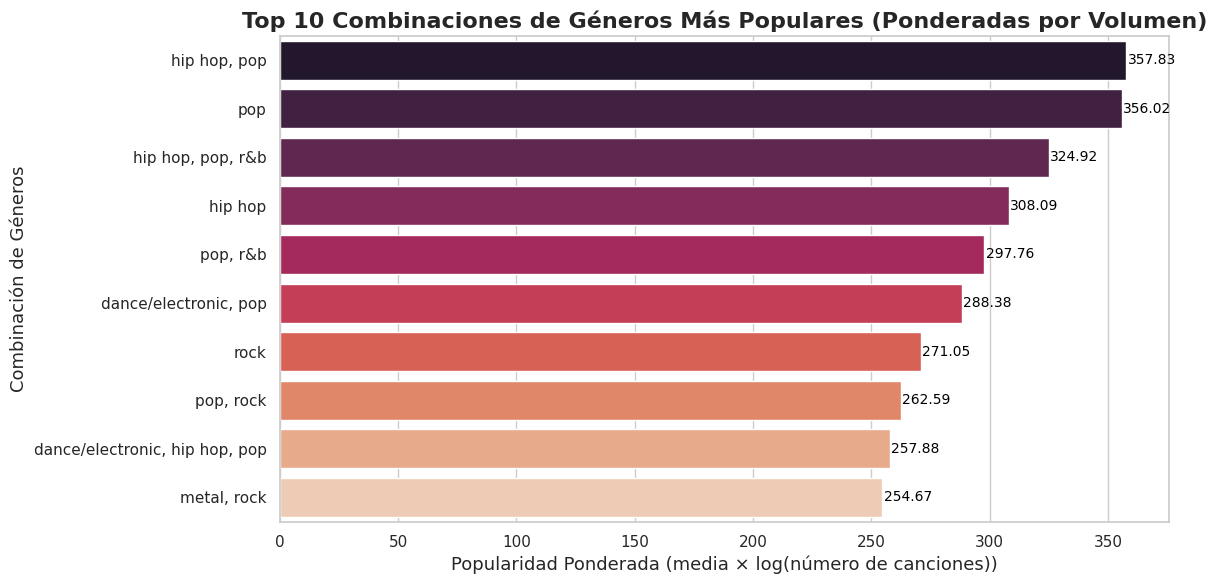

In [59]:
# Preparamos el top 10
top10 = genero_stats.sort_values(by="popularidad_ponderada", ascending=False).head(10)

# Creamos un DataFrame para seaborn
df_top10 = pd.DataFrame({
    'Género': top10['genre_clean'],
    'Popularidad_Ponderada': top10['popularidad_ponderada']
})

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Graficamos
ax = sns.barplot(
    data=df_top10,
    x='Popularidad_Ponderada',
    y='Género',
    hue='Género',
    palette='rocket',
    dodge=False,
    legend=False
)

# Títulos y etiquetas
ax.set_title(
    "Top 10 Combinaciones de Géneros Más Populares (Ponderadas por Volumen)",
    fontsize=16, weight='bold'
)
ax.set_xlabel(
    "Popularidad Ponderada (media × log(número de canciones))",
    fontsize=13
)
ax.set_ylabel(
    "Combinación de Géneros",
    fontsize=13
)

# Etiquetas dentro o al final de las barras
for i, (valor, genero) in enumerate(zip(df_top10['Popularidad_Ponderada'], df_top10['Género'])):
    ax.text(valor + 0.5, i, f"{valor:.2f}", color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()


###Explícitas VS. No Explícitas, Impacto en Popularidad?

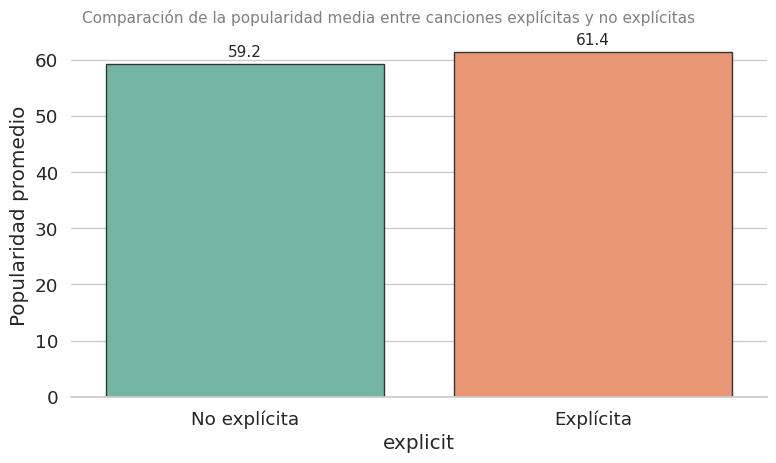

In [71]:
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 5))

groupby_explicit = df.groupby("explicit")["popularity"].agg(["mean", "count"])
groupby_explicit = groupby_explicit.rename(columns={"mean": "avg_popularity", "count": "song_count"})
ax = sns.barplot(
    data=groupby_explicit,
    x="explicit",
    y="avg_popularity",
    hue="explicit",
    palette="Set2",
    legend=False,
    edgecolor=".2"
)

# Etiquetas con los valores de las barras
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", label_type="edge", padding=3, fontsize=11)

# Títulos
plt.suptitle("Comparación de la popularidad media entre canciones explícitas y no explícitas", fontsize=11, y=0.93, color='gray')

# Ejes
plt.ylabel("Popularidad promedio")
plt.xticks([0, 1], ["No explícita", "Explícita"])

sns.despine(left=True)
plt.tight_layout()
plt.show()


###Duración Óptima


In [61]:
df["min_time"] = (df["duration_ms"] / (1000 * 60)).round(2)
bins=[0,2.5,3.5,4.5,df["min_time"].max()]
labels=["<2.5 min","2.5–3.5 min","3.5–4.5 min",">4.5 min"]
df["duration_bucket"]=pd.cut(df["min_time"],bins=bins,labels=labels)
df["duration_bucket"].value_counts()


,count
duration_bucket,
3.5–4.5 min,1050
2.5–3.5 min,609
>4.5 min,249
<2.5 min,18


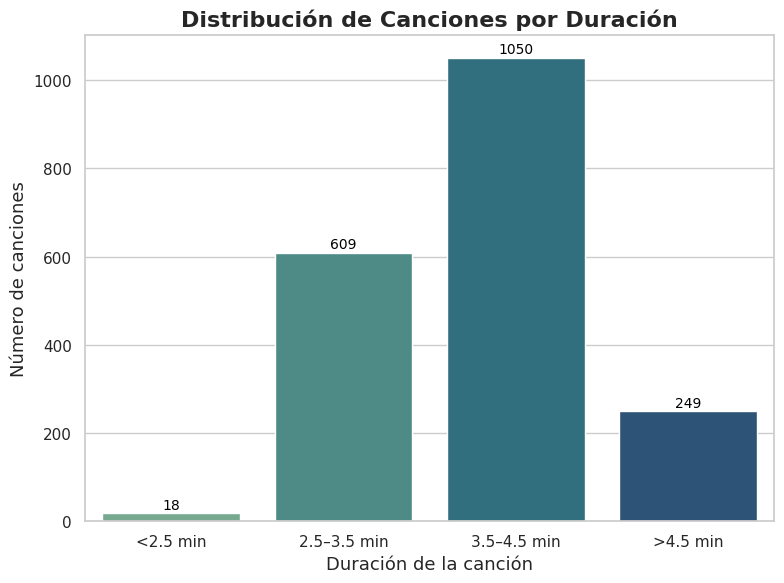

In [62]:
# Contar cuántas canciones hay por cada rango de duración
duration_counts = df["duration_bucket"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

ax = sns.barplot(
    x=duration_counts.index,
    y=duration_counts.values,
    hue=duration_counts.index,
    palette="crest",
    legend=False
)

# Títulos y etiquetas
ax.set_title(
    "Distribución de Canciones por Duración",
    fontsize=16, weight='bold'
)
ax.set_xlabel("Duración de la canción", fontsize=13)
ax.set_ylabel("Número de canciones", fontsize=13)

# Agregar los números encima de las barras
for i, v in enumerate(duration_counts.values):
    ax.text(i, v + max(duration_counts.values)*0.01, str(v), color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

###Correlación Entre Atributos

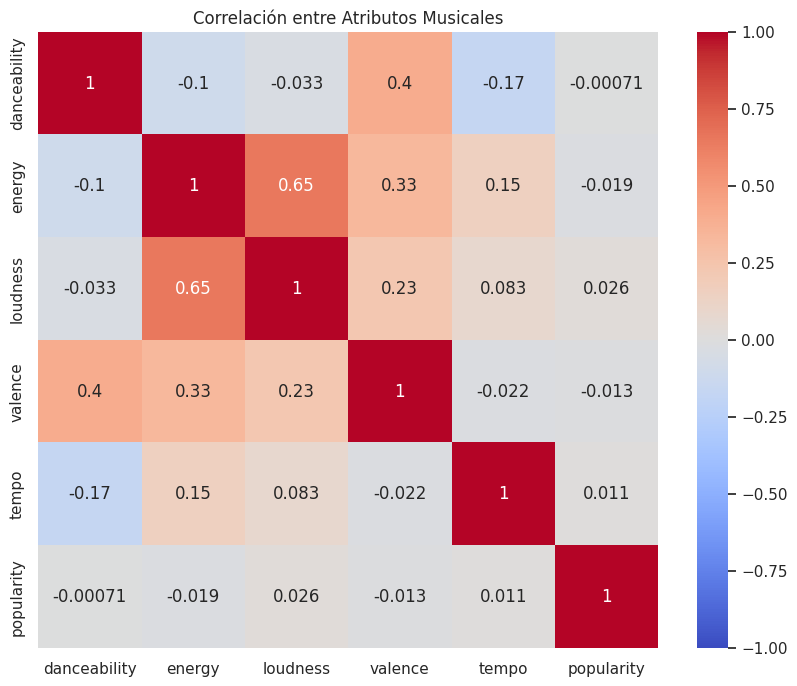

In [63]:
# Calcular correlación entre atributos
corr = df[['danceability', 'energy', 'loudness', 'valence', 'tempo',"popularity"]].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación entre Atributos Musicales')
plt.show()

###Red Interactiva de Co-ocurrencia de Géneros Musicales

In [64]:
# Preprocesamiento de datos
df['genre_list'] = df['genre'].dropna().apply(lambda x: [g.strip().lower() for g in x.split(',')])

# Generar pares de géneros y contar co-ocurrencias
genre_pairs = []
for genres in df['genre_list']:
    if len(genres) > 1:
        genre_pairs.extend(combinations(set(genres), 2))
pair_counts = Counter(genre_pairs)

# Crear grafo
G = nx.Graph()
for (g1, g2), weight in pair_counts.items():
    G.add_edge(g1, g2, weight=weight)

# Configuración visual del grafo
pos = nx.spring_layout(G, k=0.4, iterations=50)

# Preparar datos para Plotly
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x = []
node_y = []
node_text = []
node_size = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    degree = G.degree(node)
    node_size.append(10 + degree * 2)
    # Info para el tooltip
    neighbors = list(G.neighbors(node))
    top_connections = sorted([(n, G[node][n]['weight']) for n in neighbors],
                           key=lambda x: x[1], reverse=True)[:3]
    connections_str = "<br>".join([f"{n[0]}: {n[1]} canciones" for n in top_connections])
    node_text.append(f"<b>{node}</b><br>Conectado a {degree} géneros<br>Top conexiones:<br>{connections_str}")

# Crear figura
fig = go.Figure()

# Añadir aristas
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='#888'),
    hoverinfo='none',
    mode='lines')

# Añadir nodos
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=[node.capitalize() for node in G.nodes()],
    textposition="top center",
    hovertext=node_text,
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=node_size,
        color=[G.degree(node) for node in G.nodes()],
        colorbar=dict(
            thickness=15,
            title='Conexiones',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

fig.add_trace(edge_trace)
fig.add_trace(node_trace)

# Diseño de la figura
fig.update_layout(
    title='<b>Red Interactiva de Co-ocurrencia de Géneros Musicales</b><br>El tamaño del nodo representa su grado de conexión',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=800,
    clickmode='event+select'
)

# Función para resaltar conexiones al hacer clic
def update_point(trace, points, selector):
    # Esta función se activaría con eventos de Plotly
    pass

# Mostrar figura
fig.show()

###Evolución de Características Musicales a lo Largo del Tiempo

In [66]:
# Definir qué características musicales
features = [
    'danceability', 'energy', 'acousticness', 'valence', 'tempo',
    'loudness', 'speechiness', 'instrumentalness'
]

# Agrupar por año y calcular el promedio de las características
df_yearly = df.groupby('year')[features].mean().reset_index()

# Normalizar los datos a un rango [0,1] para comparación visual
scaler = MinMaxScaler()
df_yearly[features] = scaler.fit_transform(df_yearly[features])

# Reorganizar los datos en formato largo para usar en Plotly
df_melted = df_yearly.melt(
    id_vars='year',
    value_vars=features,
    var_name='FEATURES:',
    value_name='value'
)

# Crear gráfico interactivo con líneas suavizadas (spline)
fig = px.line(
    df_melted,
    x='year',
    y='value',
    color='FEATURES:',
    title='Evolución de Características Musicales a lo Largo del Tiempo',
    labels={'value': 'Valor Normalizado', 'year': 'Año'},
    line_shape='spline',
    hover_data={'value': ':.2%'},  # Muestra el valor como porcentaje
    template='plotly_dark'
)

# Personalizar el layout del gráfico
fig.update_layout(
    height=600,
    hovermode='x unified',
    legend=dict(orientation='h', yanchor='bottom', y=1.02),
    yaxis_tickformat='.0%',  # Mostrar eje Y como porcentaje
    xaxis_rangeslider_visible=True  # Agrega un slider en el eje X
)

# Mostrar el gráfico
fig.show()
